# Знакомство с библиотекой PyKEEN

PyKEEN - это пакет, разработанный для обучения и использования моделей эмбеддингов графов знаний. 

[Статья авторов об их фрейворке](https://arxiv.org/pdf/2006.13365.pdf)

Особенности и возможности PyKEEN:

1. Каждая модель (`pykeen.models`) имеет один и тот же интефрейс
2. Каждый цикл обучения (`pykeen.training`) имеет один и тот же интерфейс. 
3. Тройки могут быть сгенерированы при помощи `pykeen.triples.TriplesFactory`. 
4. Имеется высокоуровневый интерфейс для обучения моделей - `pykeen.pipeline.pipeline`
5. На момент 08.10 в PyKEEN имеется:
    - [29 датасетов](https://github.com/pykeen/pykeen#datasets-29)
    - [31 модель](https://github.com/pykeen/pykeen#models-31)
    - [9 функций потерь](https://github.com/pykeen/pykeen#losses-9)
    - [5 регуляризаторов](https://github.com/pykeen/pykeen#regularizers-5)
    - [2 цикла обучения](https://github.com/pykeen/pykeen#training-loops-2)
    - [3 генератора негативных примеров](https://github.com/pykeen/pykeen#negative-samplers-3)
    - [2 класса для оценки качества](https://github.com/pykeen/pykeen#evaluators-2)


## Обучение модели при помощи pipeline

Самый простой способ обучить модель - воспользоваться функцией `pykeen.pipeline.pipeline`. 

Основные аргументы (могут быть переданы в виде строки или соотвествующего объекта):

- dataset
- model
- training loop: sLCWA или LCWA  
    * Local Closed World Assumption: для любой тройки $(h, r, t) \in K$ создается набор отрицательных примеров $T^-(h, r)$, состоящий из всех троек $(h, r, t_i) \notin K$. Аналогично можно построить $R^-=(h, r_i, t) \notin K$ и  $H^-=(h_i, r, t) \notin K$
    * Stochastic Local Closed World Assumption: не все примеры $R^-$, $H^-$ и $T^-$ рассматриваются как негативные, вместо этого из них выбирается некоторое множество случайным образом. Негативные примеры создаются путем заменой либо $h$, либо $t$ в тройке $(h, r, t)$. Теоретически при выполнении этой процедуры нужно отфильтровать примеры, которые принадлежат выборке, но на практике этим можно пренебречь. Также стоит помнить, что тройка, не содержащаяся в графе, может все равно быть истинной.
- negative_sampler: только при использовании sLCWA
- evaluator
- stopper

Дополнительные аргументы:

- model_kwargs: словарь с аргументами, которые будут переданы в конструктор выбранной модели
- dataset_kwargs: словарь с аргументами, которые будут переданы в конструктор выбранного датасета
- optimizer_kwargs
- training_kwargs
- evaluation_kwargs

In [39]:
from pykeen.pipeline import pipeline

pipeline_result = pipeline(dataset='Nations', model='TransE')

Training epochs on cuda: 100%|██████████| 5/5 [00:00<00:00,  7.15epoch/s, loss=0.00582, prev_loss=0.00586]
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=201.
Evaluating on cuda: 100%|██████████| 201/201 [00:00<00:00, 9.57ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds


## Загрузка и сохранение модели

Для сохранения результатов `pipeline` есть метод save_to_directory

После того, как модель обучена и сохранена на диск, ее можно загрузить при помощи стандартного `torch.load` 

In [ ]:
pipeline_result.save_to_directory('nations_transe')

In [3]:
import torch
model = torch.load('nations_transe/trained_model.pkl')

## Использование эмбеддингов

In [27]:
from pykeen.pipeline import pipeline

result = pipeline(model='TransE', dataset='UMLS')
model = result.model

Training epochs on cuda: 100%|██████████| 5/5 [00:01<00:00,  4.59epoch/s, loss=0.00396, prev_loss=0.00411]
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.
Evaluating on cuda: 100%|██████████| 661/661 [00:00<00:00, 22.0ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


Эмбеддинги, полученные в результате обучения модели, могут быть в дальнейшем использованы для решения downstream задач. 

Потенциально модель может хранить несколько эмбедлингов для одного узла/отношения, поэтому они хранятся в атрибутах `entity_representations` и `relation_representations` в виде последовательностей модулей, похожих на `torch.nn.Embedding`. Первый элемент обычно означает "основной" эмбеддинг

In [15]:
from typing import List

import pykeen.nn
from pykeen.pipeline import pipeline

entity_representation_modules: List['pykeen.nn.RepresentationModule']
relation_representation_modules: List['pykeen.nn.RepresentationModule']
entity_representation_modules = model.entity_representations
relation_representation_modules = model.relation_representations

# TransE имеет по 1 эмбеддингу на сущность, поэтому берем 1 элемент
entity_embeddings: pykeen.nn.Embedding = entity_representation_modules[0]
relation_embeddings: pykeen.nn.Embedding = relation_representation_modules[0]

# чтобы получить тензор, мы делаем вызов
entity_embedding_tensor: torch.FloatTensor = entity_embeddings()
relation_embedding_tensor: torch.FloatTensor = relation_embeddings()

entity_embedding_tensor.shape

torch.Size([135, 50])

In [14]:
# при необходимости можно передать индексы интересующих узлов в виде torch.LongTensor
e_idx = torch.LongTensor([1, 10, 100]).cuda()
entity_embedding_tensor = entity_embeddings(indices=e_idx)
entity_embedding_tensor.shape

torch.Size([3, 50])

## Визуализация результатов

Training epochs on cuda: 100%|██████████| 5/5 [00:01<00:00,  4.50epoch/s, loss=0.00374, prev_loss=0.00401]
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.
Evaluating on cuda: 100%|██████████| 661/661 [00:00<00:00, 22.0ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>,
        <AxesSubplot:title={'center':'Entity/Relation Plot using PCA'}>],
       dtype=object))

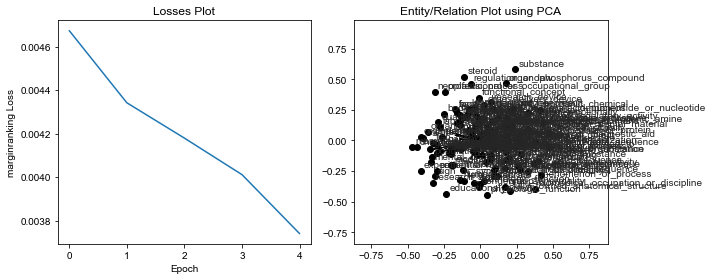

In [28]:
result = pipeline(model='TransE', dataset='UMLS')
result.plot()

## Обучение модели без использования pipeline

Обучение без использования состоит из следующих шагов:

1. Выбор датасета
2. Выбор модели
3. Выбор оптимизатора из `torch`
4. Выбор подхода к обучению (LCWA, sLCWA)
5. Обучение
6. Оценка

In [30]:
from pykeen.datasets import Nations
from pykeen.models import TransE
from torch.optim import Adam
from pykeen.training import SLCWATrainingLoop
from pykeen.evaluation import RankBasedEvaluator

# 1. Выбор датасета
dataset = Nations()
# 2. Выбор модели
model = TransE(triples_factory=dataset.training)
# 3. Выбор оптимизатора
optimizer = Adam(model.get_grad_params())
# 4. Выбор подхода к обучению
training_loop = SLCWATrainingLoop(model=model, optimizer=optimizer, 
                                  triples_factory=dataset.training)
# 5. Обучение
training_loop.train(triples_factory=dataset.training, num_epochs=5, batch_size=256)
# 6. Оценка
evaluator = RankBasedEvaluator()
result = evaluator.evaluate(model, dataset.testing.mapped_triples, batch_size=1024)

Training epochs on cuda: 100%|██████████| 5/5 [00:00<00:00,  7.12epoch/s, loss=0.00574, prev_loss=0.00606]
given. This means you probably forgot to pass (at least) the training triples. Try:

    additional_filtered_triples=[dataset.training.mapped_triples]

Or if you want to use the Bordes et al. (2013) approach to filtering, do:

    additional_filtered_triples=[
        dataset.training.mapped_triples,
        dataset.validation.mapped_triples,
    ]

Evaluating on cuda: 100%|██████████| 201/201 [00:00<00:00, 9.14ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


## Оценка результатов

`evaluator.evaluate` возвращает объект `MetricResult`, содержащий метрики для оценивания модели

Результат содержит:
1. Набор различных метрик (hits@k, MR, MRR и т.д.)
2. Для каждой метрики рассматриваются различные оценки: пессимистичная, реалистичная, оптимистичная. Пессимистичная оценка означает, что при прочих равных правильный ответ окажется в самом внизу списка прогнозов; оптимистичная - наоборот.
3. Для каждой метрики и оценки рассматриваются 3 варианта: оценка только по tail, только по head и по обоим сторонам

In [38]:
result.to_df()

,Side,Type,Metric,Value
0,both,optimistic,hits_at_1,0.000000
1,both,optimistic,hits_at_3,0.221393
2,both,optimistic,hits_at_5,0.368159
3,both,optimistic,hits_at_10,0.721393
4,both,optimistic,arithmetic_mean_rank,7.452736
...,...,...,...,...
136,head,realistic,rank_std,3.708774
137,head,realistic,rank_var,13.755006
138,head,realistic,rank_mad,3.000000
139,head,realistic,adjusted_arithmetic_mean_rank,1.033136


Одна из потенциальных проблем, связанных с методикой оценки, следующая. Если при прогнозе $t$ для тройки $(h, r, t)$, мы предскажем для некоторой тройки $(h, r, t') \in K, t\ne t'$ ранг выше, чем у самой $(h, r, t)$, то, с одной стороны, ранг увеличится (что плохо), а с другой, давать $(h, r, t')$ более высокую оценку хорошо, т.к. она правда содержится в графе. 

Filtered evaluation означает, что при оценке $(h, r, t)$ игнорируются оценки всех истинных $(h, r, t')$

## Предсказание связей

После обучения модели можно использовать для оценки правдоподобия произвольной тройки. Для моделей из PyKEEN чем выше оценка, тем более высока вероятность, что такая тройка существует. 

Важно:

- нельзя сравнивать оценки для конкретной тройки, полученные при помощи разных моделей
- не существует априорного значения порога отсечения, после которого тройку можно признать правдивой

Модели реализуют 4 метода:
- `get_tail_prediction_df` для заданной пары $(h, r)$
- `get_relation_prediction_df` для заданной пары $(h, t)$
- `get_head_prediction_df` для заданной пары $(r, t)$
- `get_all_prediction_df` для подсчета оценки для всех возможных связей

In [40]:
from pykeen.pipeline import pipeline

pipeline_result = pipeline(dataset='Nations', model='TransE')
model = pipeline_result.model

Training epochs on cuda: 100%|██████████| 5/5 [00:00<00:00,  7.03epoch/s, loss=0.0059, prev_loss=0.00603]
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=201.
Evaluating on cuda: 100%|██████████| 201/201 [00:00<00:00, 8.04ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


In [47]:
# предсказываем tail
model.get_tail_prediction_df('brazil', 'intergovorgs', 
                             triples_factory=pipeline_result.training)

,tail_id,tail_label,score,in_training
0,0,brazil,-6.412086,False
4,4,egypt,-7.917833,True
12,12,usa,-8.725386,True
10,10,poland,-8.999136,False
9,9,netherlands,-9.010881,True
3,3,cuba,-9.277218,False
1,1,burma,-9.421756,False
5,5,india,-9.657982,True
13,13,ussr,-9.847170,False
7,7,israel,-9.978243,True


In [49]:
model.get_all_prediction_df(triples_factory=pipeline_result.training)

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score,in_training
0,8,jordan,36,relexportbooks,8,jordan,-5.777510,False
1,6,indonesia,36,relexportbooks,6,indonesia,-5.777510,False
2,9,netherlands,36,relexportbooks,9,netherlands,-5.777510,False
3,4,egypt,36,relexportbooks,4,egypt,-5.777510,False
4,11,uk,36,relexportbooks,11,uk,-5.777510,False
...,...,...,...,...,...,...,...,...
10775,11,uk,23,militaryactions,10,poland,-13.048323,False
10776,11,uk,7,commonbloc1,10,poland,-13.048824,False
10777,6,indonesia,15,emigrants3,2,china,-13.078943,False
10778,0,brazil,35,relemigrants,8,jordan,-13.207655,False
